In [1]:
import requests
import pandas as pd
from barentswatch.credentials import config
from barentswatch.authentication import get_token
import warnings
from pprintpp import pprint
warnings.simplefilter(action='ignore', category=FutureWarning)

###### Using API to get data

Link to ApiDocs: https://www.barentswatch.no/bwapi/openapi/index.html?urls.primaryName=Fishhealth%20API

##### Storing information from the entire year in table

##### Activating pyspark

In [2]:
import os

os.environ["PYSPARK_PYTHON"] = r"C:\Users\holml\anaconda3\envs\IND320_ml\python.exe" 
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\holml\anaconda3\envs\IND320_ml\python.exe"
os.environ["HADOOP_HOME"] = r"C:\Source\winutils\hadoop-3.3.1"
os.environ["PYSPARK_HADOOP_VERSION"] = r"C:\Source\winutils\hadoop-3.3.1"

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

In [4]:
spark.read.format("org.apache.spark.sql.cassandra")\
.options(table="locality_data", keyspace="fish_data").load()\
.createOrReplaceTempView("locality_view")

df_locality = spark.sql("select * from locality_view").toPandas()

In [5]:
def assign_region(lat):
    if lat < 63.81:
        return 'South'
    elif lat <= 68.85:
        return 'Middle'
    else:
        return 'North'

In [6]:
print(df_locality.shape)
df_locality['region'] = df_locality['lat'].apply(assign_region)
print(df_locality.shape)
df_locality.head()

(88475, 21)
(88475, 22)


,localityweekid,avgadultfemalelice,hascleanerfishdeployed,hasila,hasmechanicalremoval,haspd,hasreportedlice,hassalmonoids,hassubstancetreatments,infilteredselection,...,isslaughterholdingcage,lat,localityno,lon,municipality,municipalityno,name,week,year,region
0,1298727,NaN,False,False,False,False,False,False,False,True,...,False,64.505967,33158,10.844533,Flatanger,5049,Kjærsundet V,37,2021,Middle
1,1341168,NaN,False,False,False,False,False,False,False,True,...,False,66.003917,10951,12.694217,Alstahaug,1820,Kjerringskjæret Sv,52,2021,Middle
2,1267743,0.00,False,False,False,False,True,True,False,True,...,False,60.868183,12154,5.551717,Masfjorden,4634,Smørdalen,27,2021,South
3,1193413,0.40,False,False,False,True,True,True,False,True,...,False,64.243367,19135,10.263817,Åfjord,5058,Sandøya III,4,2021,Middle
4,1273974,0.02,False,False,False,False,True,True,True,True,...,False,68.583933,10505,14.707267,Hadsel,1866,Dragnes,29,2021,Middle


In [7]:
#Group by week and avgAdultFemaleLice
df_grouped = df_locality.groupby(['week', 'avgadultfemalelice']).size().reset_index(name='counts')

In [8]:

df_pivot1 = df_locality.pivot_table(index='hasila', columns='haspd', values=['lat', 'lon'], aggfunc='mean')
df_pivot1.head()

lat                   lon          
haspd       False      True       False     True 
hasila                                           
False   64.127945  61.451657  10.855804  6.409310
True    67.357973  59.295500  16.327834  5.938617

##### Comments about pivot table1

We see that the mean latitude for False and False is further North than True and True. Colder water further north could be a reason for this to happen.

<Axes: xlabel='week'>

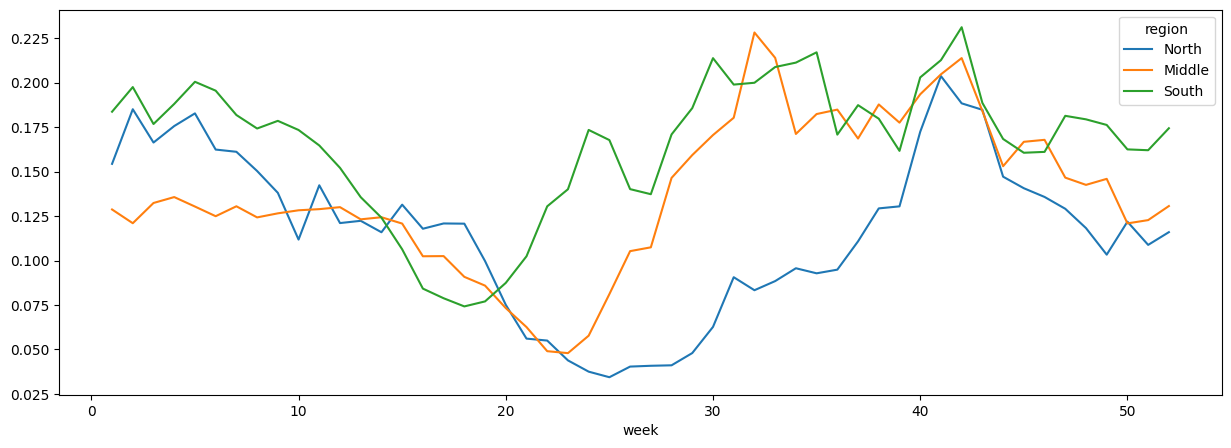

In [9]:
df_pivot2 = df_locality.pivot_table(index='week', columns='region',\
                                    values='avgadultfemalelice', aggfunc='mean')
df_pivot2.plot(y=['North', 'Middle', 'South'], kind='line', figsize=(15, 5))

#df_pivot2.head(52)

#### Comments on plot

From the plot we see that the amount of lice. It corresponds with the seatemperature, which makes sense since the viruses thrives/grotwth best in warm water. 
Maybe the delay from summer is due to "golfstrømmen" will need time to reach norway?

### Lookin at the more detailed data from a single locality

- ID = 35297


In [10]:
spark.read.format("org.apache.spark.sql.cassandra")\
.options(table="id_35297", keyspace="fish_data").load()\
.createOrReplaceTempView("id_35297")

df_35297 = spark.sql("select * from id_35297").toPandas()

In [11]:
df_35297.shape

(52, 6)

<Axes: xlabel='datetime'>

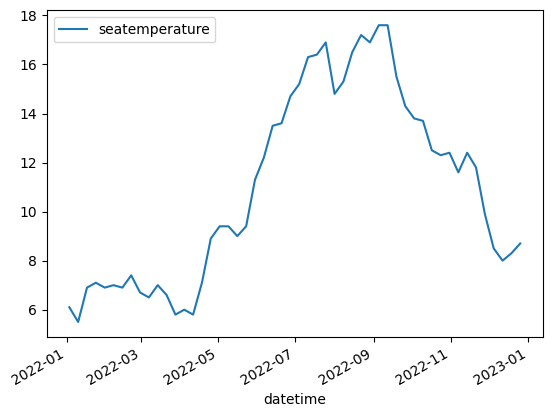

In [12]:
#plot seaTemperature
df_35297["datetime"] = pd.to_datetime(df_35297["datetime"], format='%Y-%W-%w')
#Set index to datetime  

df_35297.plot(x ="datetime", y='seatemperature')

#### Seeing the correlation between seatemperature and "mobilse, stationary and adultfemalelice"

In [13]:
from matplotlib import pyplot as plt

import numpy as np
from ipywidgets import interact
datetine_idx = df_35297.copy()
def lagged_correlation_plot(lag=0, window=45, center=22, variable='avgadultfemalelice'):
    corr = np.corrcoef(y[lag:], x[variable][0:len(x)-lag])

    z = x[variable].copy()
    z.index += lag
    seatemp_SWC = y.rolling(window, center=True).corr(z)
#    PerEURO_SWC = y[lag:].rolling(window, center=True).corr(x[variable][:len(x)-lag])

    # Plot Seatemperature, [] and PerEUROs_SWC as subplots
    plt.subplot(3,1,1)
    plt.plot(datetine_idx['seatemperature'])
    plt.plot(range(np.max([0,center-window//2+lag]),np.min([center+window//2+lag, len(y)])), \
        df_35297['seatemperature'][np.max([0,center-window//2+lag]):np.min([center+window//2+lag, len(y)])], color="red")
    plt.ylabel('seatemperature')
    plt.xlim(0, len(y))
    plt.subplot(3,1,2)
    plt.plot(datetine_idx[variable])
    plt.plot(range(np.max([0,center-window//2]),np.min([center+window//2, len(y)])), \
        datetine_idx[variable][np.max([0,center-window//2]):np.min([center+window//2, len(y)])], color="red")
    plt.ylabel(variable)
    plt.xlim(0, len(y))
    plt.subplot(3,1,3)
    plt.plot(seatemp_SWC)
    plt.plot(center+lag, seatemp_SWC[center+lag], 'r.')
    plt.axhline(y=0, color='gray', linestyle=':')
    plt.ylim(-1,1)
    plt.xlim(0, len(y))
    plt.xlabel('Time')
    plt.ylabel('°C')
    plt.show()
    print("Correlation between {} and {} lagged {} timepoints: {:.3f}".format(y.name, variable, lag, corr[0,1]))

x = datetine_idx
y = datetine_idx['seatemperature']
interact(lagged_correlation_plot, lag=(0,52,1), window=(1,52,1), center=(0,len(df_35297['seatemperature'])-22,1),\
        variable=["avgadultfemalelice", "avgmobilelice", "avgstationaryulice"]); # Semi-colon to suppress output


interactive(children=(IntSlider(value=0, description='lag', max=52), IntSlider(value=45, description='window',…

##### Comments to avgadultfemalelice

Can clearly see that there is a correlation beetween 

In [14]:

spark.createDataFrame(df_35297).write.format("org.apache.spark.sql.cassandra")\
.options(table="id_35297", keyspace="fish_data").mode("append").save()

In [15]:
spark.read.format("org.apache.spark.sql.cassandra").options(table="id_35297", keyspace="fish_data").load().show()

+--------------------+------------------+-------------+-----------------+---------------+--------------+
|            datetime|avgadultfemalelice|avgmobilelice|avgstationarylice|hasreportedlice|seatemperature|
+--------------------+------------------+-------------+-----------------+---------------+--------------+
|2022-05-16 00:00:...|               0.1|         0.55|             0.25|           true|           9.0|
|           2022-24-1|              0.19|         1.16|             0.26|           true|          13.5|
|2022-01-24 00:00:...|              0.09|         0.34|             0.06|           true|           7.1|
|2022-05-02 00:00:...|              0.04|         0.16|             0.08|           true|           9.4|
|2022-11-14 00:00:...|              0.05|         0.28|             0.02|           true|          12.4|
|           2022-45-1|              0.02|         0.42|             0.05|           true|          11.6|
|2022-02-07 00:00:...|              0.15|         0.68|

### Inserting the weather data from Frost

In [16]:
from frost_credentials.credentials import ID
import requests
client_id = ID['client_id']
client_secret = ID['client_secret']

In [17]:
#Closest station to 35297 fishing station
id = "SN65310"

In [18]:
endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': f'{id}',
    'elements': 'mean(air_temperature P1D),\
        sum(precipitation_amount P1D),\
        mean(wind_speed P1D),\
        mean(relative_humidity P1D),\
        mean(seaTemperature P1D),)',
    'referencetime': '2022-01-01/2023-01-01'}
r = requests.get(endpoint, parameters, auth=(client_id,''))

json = r.json()

if r.status_code == 200:
    obs_data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!


In [19]:
# This will return a Dataframe with all of the observations in a table format
df_total = pd.DataFrame()
for i in range(len(obs_data)):
    row = pd.DataFrame(obs_data[i]['observations'])
    row['referenceTime'] = obs_data[i]['referenceTime']
    row['sourceId'] = obs_data[i]['sourceId']
    df_total = pd.concat([df_total, row])
df_total.head()

,elementId,value,unit,level,timeOffset,timeResolution,timeSeriesId,performanceCategory,exposureCategory,qualityCode,referenceTime,sourceId
0,mean(air_temperature P1D),3.0,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,0.0,2022-01-01T00:00:00.000Z,SN65310:0
1,mean(air_temperature P1D),4.6,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT6H,P1D,0,C,2,NaN,2022-01-01T00:00:00.000Z,SN65310:0
2,mean(wind_speed P1D),6.4,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,2.0,2022-01-01T00:00:00.000Z,SN65310:0
3,mean(relative_humidity P1D),72.0,percent,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,0.0,2022-01-01T00:00:00.000Z,SN65310:0
0,mean(air_temperature P1D),6.8,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,0.0,2022-01-02T00:00:00.000Z,SN65310:0


In [20]:
# These additional columns will be kept
columns = ['sourceId','referenceTime','elementId','value','unit','timeOffset'] 
df = df_total[columns].copy()
df['datetime'] = pd.to_datetime(df['referenceTime'])
def convert_to_week_format(dt):
    return dt.strftime('%Y-%W-%w')
# Apply the function to the datetime column
df['datetime'] = df['datetime'].apply(convert_to_week_format)
df.drop(columns=["referenceTime"], inplace=True) #Removing referenceTime column





In [21]:
df.head()

,sourceId,elementId,value,unit,timeOffset,datetime
0,SN65310:0,mean(air_temperature P1D),3.0,degC,PT0H,2022-00-6
1,SN65310:0,mean(air_temperature P1D),4.6,degC,PT6H,2022-00-6
2,SN65310:0,mean(wind_speed P1D),6.4,m/s,PT0H,2022-00-6
3,SN65310:0,mean(relative_humidity P1D),72.0,percent,PT0H,2022-00-6
0,SN65310:0,mean(air_temperature P1D),6.8,degC,PT0H,2022-00-0


### Using a pivot table to make the weather table format better
- For each day, the value will be the average of all measurements
- Will ensure one row for each day, making future implementations and vizualising easier.

In [22]:
df_pivoted = df.pivot_table(index=['sourceId', 'datetime'], 
                            columns='elementId', 
                            values='value', 
                            aggfunc='mean').reset_index()
print(df_pivoted.shape)
df_pivoted.head(10)

(365, 5)


elementId,sourceId,datetime,mean(air_temperature P1D),mean(relative_humidity P1D),mean(wind_speed P1D)
0,SN65310:0,2022-00-0,5.40,86.0,10.2
1,SN65310:0,2022-00-6,3.80,72.0,6.4
2,SN65310:0,2022-01-0,1.05,73.0,3.8
3,SN65310:0,2022-01-1,5.15,90.0,7.0
4,SN65310:0,2022-01-2,2.40,77.0,6.6
5,SN65310:0,2022-01-3,1.65,78.0,8.7
6,SN65310:0,2022-01-4,1.50,82.0,5.2
7,SN65310:0,2022-01-5,0.05,76.0,5.2
8,SN65310:0,2022-01-6,1.10,88.0,3.3
9,SN65310:0,2022-02-0,5.25,80.0,20.0


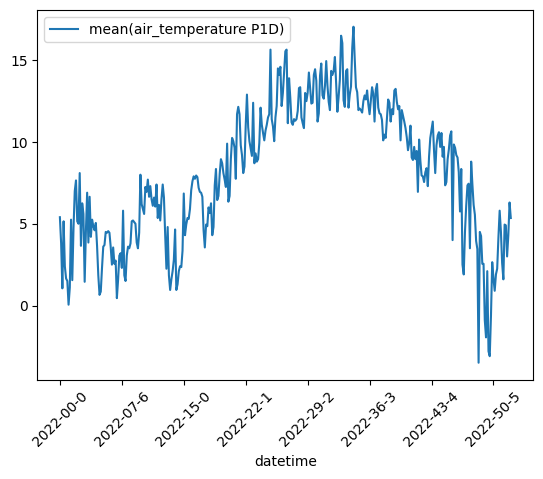

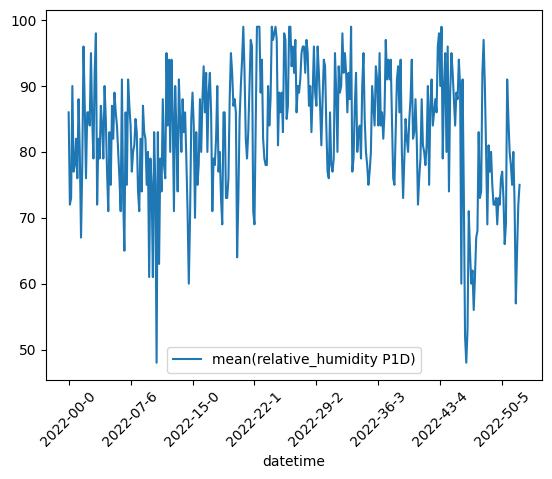

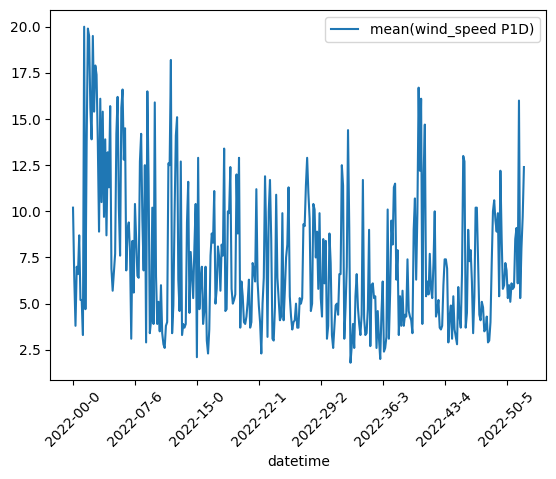

In [23]:
for element in df_pivoted.columns[2:]:
    df_pivoted.plot(x = 'datetime', y=element, rot=45)

##### Merging the weather dataset with fishhealth dataset based on timepoints.
- Using right join to have one measurement per week

In [40]:
df_35297['datetime'] = pd.to_datetime(df_35297['datetime'])
df_pivoted['datetime'] = pd.to_datetime(df_pivoted['datetime'])

In [51]:
df_35297['datetime'] 

0    2022-06-20
1    2022-11-21
2    2022-06-13
3    2022-11-07
4    2022-10-10
5    2022-11-28
6    2022-11-14
7    2022-07-18
8    2022-12-12
9    2022-02-21
10   2022-07-11
11   2022-01-31
12   2022-10-03
13   2022-08-22
14   2022-01-03
15   2022-05-30
16   2022-07-25
17   2022-04-18
18   2022-12-26
19   2022-10-31
20   2022-03-28
21   2022-05-16
22   2022-01-24
23   2022-09-26
24   2022-12-19
25   2022-09-05
26   2022-08-15
27   2022-02-14
28   2022-04-11
29   2022-02-28
30   2022-02-07
31   2022-03-14
32   2022-03-21
33   2022-10-17
34   2022-05-23
35   2022-10-24
36   2022-06-06
37   2022-07-04
38   2022-08-01
39   2022-09-19
40   2022-04-04
41   2022-05-09
42   2022-09-12
43   2022-12-05
44   2022-03-07
45   2022-08-08
46   2022-04-25
47   2022-06-27
48   2022-08-29
49   2022-01-17
50   2022-05-02
51   2022-01-10
Name: datetime, dtype: datetime64[ns]

In [52]:
df_pivoted['datetime']

0     2022-01-02
1     2022-01-01
2     2022-01-09
3     2022-01-03
4     2022-01-04
         ...    
360   2022-12-27
361   2022-12-28
362   2022-12-29
363   2022-12-30
364   2022-12-31
Name: datetime, Length: 365, dtype: datetime64[ns]

In [69]:
merged_df2 = pd.merge(df_pivoted, df_35297, on='datetime', how="right")

In [70]:
merged_df2['datetime'] = pd.to_datetime(merged_df2['datetime'], format='%Y-%U-%w')
merged_df2.set_index('datetime', inplace=True)
merged_df2.sort_index(inplace=True)

In [71]:
merged_df2.index

DatetimeIndex(['2022-01-03', '2022-01-10', '2022-01-17', '2022-01-24',
               '2022-01-31', '2022-02-07', '2022-02-14', '2022-02-21',
               '2022-02-28', '2022-03-07', '2022-03-14', '2022-03-21',
               '2022-03-28', '2022-04-04', '2022-04-11', '2022-04-18',
               '2022-04-25', '2022-05-02', '2022-05-09', '2022-05-16',
               '2022-05-23', '2022-05-30', '2022-06-06', '2022-06-13',
               '2022-06-20', '2022-06-27', '2022-07-04', '2022-07-11',
               '2022-07-18', '2022-07-25', '2022-08-01', '2022-08-08',
               '2022-08-15', '2022-08-22', '2022-08-29', '2022-09-05',
               '2022-09-12', '2022-09-19', '2022-09-26', '2022-10-03',
               '2022-10-10', '2022-10-17', '2022-10-24', '2022-10-31',
               '2022-11-07', '2022-11-14', '2022-11-21', '2022-11-28',
               '2022-12-05', '2022-12-12', '2022-12-19', '2022-12-26'],
              dtype='datetime64[ns]', name='datetime', freq=None)

##### SARIMAX to predict one day ahead and compare against results

In [72]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(endog=merged_df2['seatemperature'].loc[:'2022-12-31'],\
                                exog = merged_df2.loc[:, merged_df2.columns[2:5]].loc[:'2022-12-31'], \
    trend='c', order=(1, 1,1), seasonal_order=(1,1,1,12))
res = mod.fit(disp=False)

c:\Users\holml\anaconda3\envs\IND320_ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\holml\anaconda3\envs\IND320_ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\holml\anaconda3\envs\IND320_ml\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [73]:
# In-sample one-step-ahead prediction wrapper function
predict = res.get_prediction()
predict_ci = predict.conf_int()

In [76]:
# Dynamic predictions starting from 2013-01-01
predict_dy = res.get_prediction(dynamic='2022-01-03')
predict_dy_ci = predict_dy.conf_int()

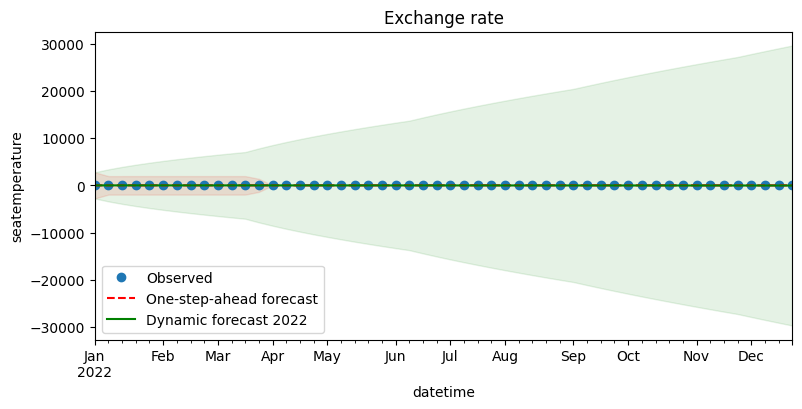

In [77]:
# Compare the one-step-ahead predictions to the dynamic predictions
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Exchange rate', xlabel='Date', ylabel='seatemperature')

# Plot data points
merged_df2.loc['2022-01-03':, 'seatemperature'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2022-01-03':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2022-01-03':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['2022-01-03':].plot(ax=ax, style='g', label='Dynamic forecast 2022')
ci = predict_dy_ci.loc['2022-01-03':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower left')

#ax.set_ylim(0, 30)

(-10.0, 30.0)

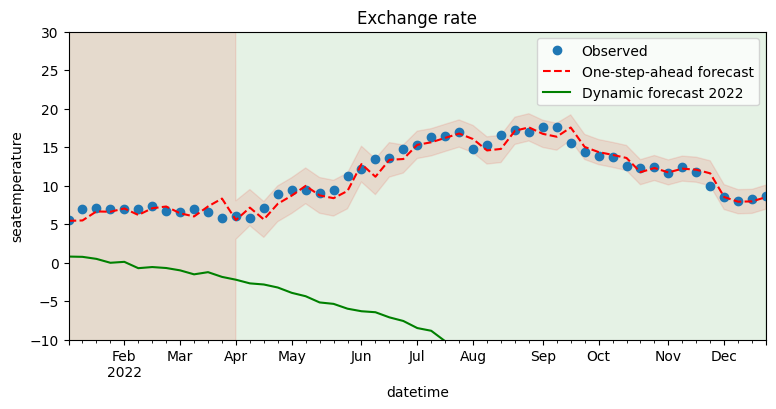

In [79]:
#Setting the ylim
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Exchange rate', xlabel='Date', ylabel='seatemperature')

# Plot data points
merged_df2.loc['2022-01-09':, 'seatemperature'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2022-01-09':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2022-01-09':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['2022-01-09':].plot(ax=ax, style='g', label='Dynamic forecast 2022')
ci = predict_dy_ci.loc['2022-01-09':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='upper right')

ax.set_ylim(-10, 30)


#### Comments on plots

The first plot is without limitation on the y-value


- We see that the one step ahead forecast doeas relatively good, but does have a big error in april.
- The reason for the green area is that the dynamic forecast has such a confidence interval

This might be beacause the data is non stationary over one year time span